In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.mixture import GaussianMixture
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans

In [3]:
!unzip /content/credit_card_dataset.zip

Archive:  /content/credit_card_dataset.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Part A : Baseline Model and Data Analysis

In [5]:
credit_card_df=pd.read_csv('/content/creditcard.csv')

No. of fair transactions =  284315
No. of fraud transactions =  492


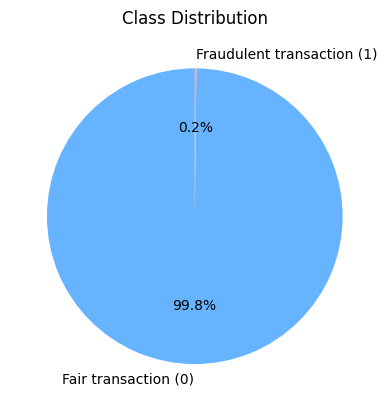

In [6]:
class_counts=credit_card_df['Class'].value_counts()
print("No. of fair transactions = ", class_counts[0])
print("No. of fraud transactions = ", class_counts[1])
labels=['Fair transaction (0)', 'Fraudulent transaction (1)']
plt.figure()
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Class Distribution')
plt.show()

In [7]:
X=credit_card_df.drop(columns=['Class'])
y=credit_card_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify=y ensures that the test set retains the original imbalance ratio in the training and testing data

model_1=LogisticRegression()
model_1.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
y_pred_1=model_1.predict(X_test)
print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred_1))
print(classification_report(y_test, y_pred_1))
print("Accuracy = ", accuracy_score(y_test, y_pred_1))
print("Precision = ", precision_score(y_test, y_pred_1))
print("Recall = ", recall_score(y_test, y_pred_1))
print("F1 score = ", f1_score(y_test, y_pred_1))

Confusion Matrix :
 [[56832    32]
 [   26    72]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.73      0.71        98

    accuracy                           1.00     56962
   macro avg       0.85      0.87      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy =  0.9989817773252344
Precision =  0.6923076923076923
Recall =  0.7346938775510204
F1 score =  0.7128712871287128


# Part B : Gaussian Mixture Model for Synthetic Sampling

Gaussian Mixture Model is a probabilistic clustering technique that models the minority class as a combination of multiple Gaussian distributions from which synthetic samples are then drawn. Synthetic Minority Oversampling Technique (SMOTE) works by creating synthetic samples for the minority class by linear interpolation. The fundamental difference is that Gaussian Mixture Model samples from a probabilistic density estimation of the minority samples, while simpler methods sample points directly from the feature space, through linear interpolation, clustering etc.

GMM is theoretically better at capturing the underlying data distribution, especially for the minority class with multiple sub-groups or complex shapes, due to its probabilistic and flexible modeling approach.

*   GMM models data as a mixture of Gaussians, allowing it to capture overlapping sub-groups or clusters within the minority class, even if they overlap or have distinct statistical properties. Each Gaussian component cna capture a separate region of the feature space, making it effective for complex, multimodal distributions.
*   GMM allows for elliptical clusters with varying orientations, sizes and covariances. The use of full covariance matrices allows GMM to represent the true geometrical structure and orientation of clusters, even if they are not spherical.

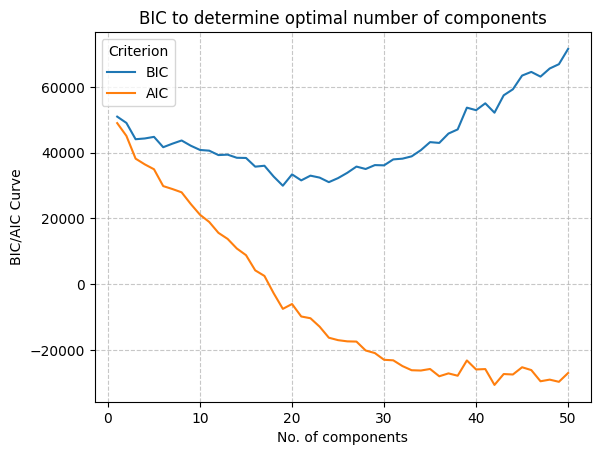

In [9]:
X_minority=X_train[y_train==1]
y_minority=y_train[y_train==1]
n_components=np.arange(1, 51)
models=[GaussianMixture(k, covariance_type='full').fit(X_minority) for k in n_components]
bic_results=[gmm.bic(X_minority) for gmm in models]
aic_results=[gmm.aic(X_minority) for gmm in models]
plt.plot(n_components, bic_results, label="BIC")
plt.plot(n_components, aic_results, label="AIC")
plt.xlabel('No. of components')
plt.ylabel('BIC/AIC Curve')
plt.title('BIC to determine optimal number of components')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Criterion')
plt.show()

Optimal number of components is decided by the minima (elbow) of the BIC curve

In [10]:
optimal_components=np.argmin(bic_results)
print(optimal_components)

18


In [11]:
optimal_model=GaussianMixture(n_components=optimal_components, covariance_type='full').fit(X_minority)
n_maj=(y_train==0).sum()
n_min=(y_train==1).sum()
n_samples=n_maj-n_min
X_synthetic, y_synthetic = optimal_model.sample(n_samples)
y_synthetic=np.ones(len(X_synthetic))
X_synthetic=pd.DataFrame(X_synthetic, columns=X_train.columns)
X_train_gmm=pd.concat([X_train, X_synthetic], ignore_index=True)
y_train_gmm=pd.concat([y_train, pd.Series(y_synthetic)])
print("Before synthetic sampling = ", y_train.value_counts())
print("After synthetic sampling = ", y_train_gmm.value_counts())

Before synthetic sampling =  Class
0    227451
1       394
Name: count, dtype: int64
After synthetic sampling =  0.0    227451
1.0    227451
Name: count, dtype: int64


Sampling from a Gaussian Mixture Model :

*   First, a single Gaussian component is selected at random according to the mixture weights, which describe the probability of choosing each component in the mixture
*   After selecting a component, a sample is drawn from that component’s Gaussian distribution, defined by its specific mean and covariance



In [28]:
X_majority=X_train[y_train==0]
y_majority=y_train[y_train==0]
majority_size=int(np.sqrt(len(X_majority)))
sampling_strat={0 : majority_size, 1 : len(X_minority)}
undersampling=ClusterCentroids(sampling_strategy=sampling_strat, random_state=42, estimator=KMeans()) # uses K-Means to find the clusters within the training data of the majority class
X_under, y_under=undersampling.fit_resample(X_train, y_train)
X_maj_under=X_under[y_under==0]
y_maj_under=y_under[y_under==0]
n_major=len(y_maj_under)
n_minor=len(X_minority)
n=n_major-n_minor
print(n)
X_syn_over, y_syn_over = optimal_model.sample(n)
y_syn_over=np.ones(len(X_syn_over))
X_syn_over=pd.DataFrame(X_syn_over, columns=X_train.columns)
X_train_cbu_gmm=pd.concat([X_maj_under, X_minority, X_syn_over], ignore_index=True)
y_train_cbu_gmm=pd.concat([y_maj_under, y_minority, pd.Series(y_syn_over)])
print("Before CBU + GMM rebalancing = ", y_train.value_counts())
print("After CBU + GMM rebalancing = ", y_train_cbu_gmm.value_counts())

82
Before CBU + GMM rebalancing =  Class
0    227451
1       394
Name: count, dtype: int64
After CBU + GMM rebalancing =  0.0    476
1.0    476
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (383) found smaller than n_clusters (394). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [29]:
model_2=LogisticRegression()
model_2.fit(X_train_gmm, y_train_gmm)
y_pred_2=model_2.predict(X_test)
print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred_2))
print(classification_report(y_test, y_pred_2))
print("Accuracy = ", accuracy_score(y_test, y_pred_2))
print("Precision = ", precision_score(y_test, y_pred_2))
print("Recall = ", recall_score(y_test, y_pred_2))
print("F1 score = ", f1_score(y_test, y_pred_2))

Confusion Matrix :
 [[55286  1578]
 [    9    89]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Accuracy =  0.9721393209508093
Precision =  0.05338932213557288
Recall =  0.9081632653061225
F1 score =  0.1008498583569405


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
model_3=LogisticRegression()
model_3.fit(X_train_cbu_gmm, y_train_cbu_gmm)
y_pred_3=model_3.predict(X_test)
print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred_3))
print(classification_report(y_test, y_pred_3))
print("Accuracy = ", accuracy_score(y_test, y_pred_3))
print("Precision = ", precision_score(y_test, y_pred_3))
print("Recall = ", recall_score(y_test, y_pred_3))
print("F1 score = ", f1_score(y_test, y_pred_3))

Confusion Matrix :
 [[49440  7424]
 [    7    91]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     56864
           1       0.01      0.93      0.02        98

    accuracy                           0.87     56962
   macro avg       0.51      0.90      0.48     56962
weighted avg       1.00      0.87      0.93     56962

Accuracy =  0.8695446086864927
Precision =  0.01210911510312708
Recall =  0.9285714285714286
F1 score =  0.023906475765138577


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
results={
    "Baseline" : {"Precision" : precision_score(y_test, y_pred_1), "Recall" : recall_score(y_test, y_pred_1), "F1 score" : f1_score(y_test, y_pred_1)},
    "GMM" : {"Precision" : precision_score(y_test, y_pred_2), "Recall" : recall_score(y_test, y_pred_2), "F1 score" : f1_score(y_test, y_pred_2)},
    "CBU + GMM" : {"Precision" : precision_score(y_test, y_pred_3), "Recall" : recall_score(y_test, y_pred_3), "F1 score" : f1_score(y_test, y_pred_3)}
}

results_df=pd.DataFrame(results).T
print(results_df)

           Precision    Recall  F1 score
Baseline    0.692308  0.734694  0.712871
GMM         0.053389  0.908163  0.100850
CBU + GMM   0.012109  0.928571  0.023906


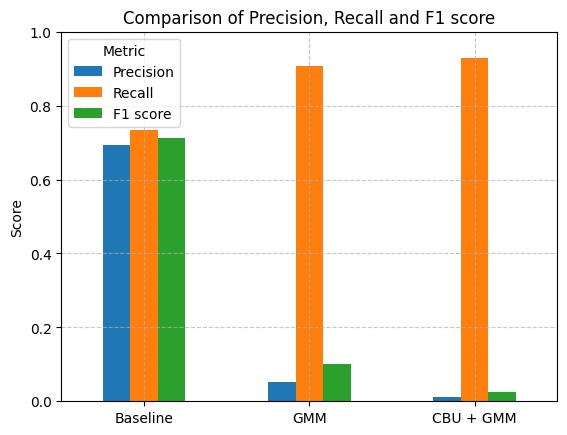

In [16]:
results_df.plot(kind="bar")
plt.ylabel("Score")
plt.title("Comparison of Precision, Recall and F1 score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The comparison of performance metrics show that the recall score (the proportion of actual fraud cases that were correctly identified as fraud by the model) has improved significantly by the GMM-based oversampling technique and the combination of clustering-based undersampling and GMM-based oversampling. Thus, both the methods improve the model's ability to detect the minority class.

**Final recommendation** : The aim of the company is to maximize the prediction of fraudulent transactions. Hence the model with the maximum recall score (the proportion of actual fraud cases that were correctly identified as fraud by the model) is the best performing model. From the performance metrics, it can be observed that the **CBU + GMM** model is the best performing model in terms of the recall score. Theoretically, this can be attributed to the reduction in redundant majority class samples by clustering based undersampling and a proportionate increase in the number of minority class samples, making the dataset more balanced

However, it comes at a significant cost of reduction in the precision, which can be improved by tuning the Logistic Regression threshold or other hyperparameters. The CBU + GMM performance can be improved by iterating over different ratios of the split and choosing the one that maximizes the performance